In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import dsntnn

In [2]:
import matplotlib
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
ordered_verts = ['T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4']
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'orange', 'brown', 'pink', 'purple', 'white', 'gray', 'olive']

# Collect results:
<ol>
    <li>Patient score<br>
    <li>Level score<br>
<ol>

### Get predictions

In [4]:
predictions = np.load('../outputs/predictions.npz')
ids, coords, dists, labels = predictions.values()
ids.shape, coords.shape, dists.shape, labels.shape

((46,), (46, 13), (46, 13, 512, 1), (46, 13))

Format predictions.<br> **Note**: Only interested in levels we know are present.

In [5]:
pred_dict = {}
for i, name in enumerate(ids):
    tmp = coords[i]
    mask = labels[i]
    pred_dict[name] = {}
    for idx in range(len(mask)):
        if mask[idx] == 1:
            vert = ordered_verts[idx]
            coord = dsntnn.normalized_to_pixel_coordinates(tmp[idx], size=dists.shape[-2])
            pred_dict[name][vert] = coord
        else:
            continue

Format distributions.

In [6]:
distribution_dict = {}
for i, name in enumerate(ids):
    distribution_dict[name] = dists[i, ..., 0]

### Get annotation info for converting to $mm$

In [7]:
from ast import literal_eval

In [8]:
pix_info = pd.read_csv(f'../images_sagittal/annotation_info.csv', index_col='Name')
pix_info.head()

,Padding,Pixel Scaling
Name,,
03_06_2014_389_Sag,"(42.0, 42.0)","(1.1640625, 1.1640625)"
03_06_2014_402_Sag,"(-96.0, -96.0)","(0.625, 0.625)"
03_06_2014_396_Sag,"(-63.0, -63.0)","(0.75200004576, 0.75200004576)"
03_06_2014_395_Sag,"(-90.0, -90.0)","(0.6480000019200001, 0.6480000019200001)"
03_06_2014_399_TS_Sag,"(-96.0, -96.0)","(0.625, 0.625)"


### Get ground-truth

In [9]:
def get_gt(id_):
    path = f'../data/testing/targets/'
    #image
    img_path = f'../data/testing/slices/sagittal/{id_}.npy'
    img = np.load(img_path)
    # Coordinates
    coord_path = path + f'coordinates/{id_}.csv'
    coords = pd.read_csv(coord_path, index_col='Level').sort_values(by='Coordinate')
    # Heatmaps
    dist_path = path + f'heatmaps/{id_}.npy'
    dists = np.load(dist_path)
    return coords, dists, img

In [10]:
coord_dict = {}
for name in ids:
    coords, dists, img = get_gt(name)
    coord_dict[name] = coords

In [11]:
def make_labels(coord_dict):
    # Use halfway point between neighbouring levels as boundary
    # Coord dict=  patient specific coordinates
    gt_dict = {}
    for i, (level, data) in enumerate(coord_dict.iterrows()):
        coord = data.to_list()[0]
        dif = coord_dict['Coordinate']-coord
        if i ==0:
            nn = coord_dict.iloc[(dif).abs().argsort()[1]]
            dist = np.abs(dif[nn.name])
            range_ = [coord-dist/2, coord, coord+dist/2]
            gt_dict[level] = range_
        elif i > 0 and i < len(coord_dict.index)-1:
            nn = coord_dict.iloc[(dif).abs().argsort()[1:3]]
            for vert in nn.index.to_list():
                rel_dist = ordered_verts.index(vert)-ordered_verts.index(level)
                if rel_dist < 0:
                    up_nn = np.abs(dif[vert])
                elif rel_dist > 0:
                    down_nn = np.abs(dif[vert])
                else:
                    print('Indexing has gone wrong')
                    break
            range_ = [coord - up_nn/2, coord, coord + down_nn/2]
            gt_dict[level] = range_
        else:
            nn = coord_dict.iloc[(dif).abs().argsort()[1]]
            dist = np.abs(dif[nn.name])
            range_ = [coord - dist/2, coord, coord+dist/2]
            gt_dict[level] = range_
    return gt_dict

#### Make labels (range = dist. to NN/2)

Each entry: Min Range, Center point, Max Range

In [12]:
all_gt = {}
for name in ids:
    gt_dict = make_labels(coord_dict[name])
    all_gt[name] = gt_dict

## Evaluate predictions
(`all_gt` & `pred_dict`)

In [86]:
def plot_preds(name, pred_dict):
    #Inputs are patient-specific
    gt, pred = all_gt[name], pred_dict[name]
    img = np.load(f'../data/testing/slices/sagittal/{name}.npy')
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    ax.imshow(img)
        
    plot_gt = np.zeros((512, 512), dtype=np.uint8)
    
    # Plot ground-truth
    for i, (level, range_) in enumerate(gt.items()):
        channel = ordered_verts.index(level)
        min_range, center, max_range = range_
        rec = patches.Rectangle((0, min_range), 512, max_range-min_range, facecolor=None, 
                                edgecolor='w', linewidth=4, alpha=0.8,fill=False, hatch=None)
        ax.add_patch(rec)
        ax.text(490, center, level, color='w')
        pred_coord = pred[level]
        if pred_coord > min_range and pred_coord < max_range:
            ax.axhline(pred_coord, ls='--', c='lawngreen', lw=4)
            ax.text(5, pred_coord-5, level, color='lawngreen')
        else:
            ax.axhline(pred_coord, ls='--', c='orangered', lw=4)
            ax.text(5, pred_coord-5, level, color='orangered')
    #fig.savefig(f'../outputs/predictions/{name}.png')
    #plt.close()
    

In [14]:
plot_preds('fr_552_TS_Sag', pred_dict)

In [78]:
def get_scores(name, pred_dict, plot=False):
    if plot:
        plot_preds(name, pred_dict)
    #Inputs are patient-specific
    gt, pred = all_gt[name], pred_dict[name]
    img = np.load(f'../data/testing/slices/sagittal/{name}.npy')
    plot_gt = np.zeros((512, 512), dtype=np.uint8)
    level_list = []
    correct_list = []
    dist_list = []
    range_list = []
    for i, (level, range_) in enumerate(gt.items()):
        channel = ordered_verts.index(level)
        min_range, center, max_range = range_
        if level not in pred.keys():
            scores_dict[level] = {'Correct': 'Not Predicted',
                                  'Distance': 'N/a'}
            level_list.append(level)
            correct_list.append('Not Predicted')
            dist_list.append('N/A')
            range_list.append(pix_scale[0]*np.abs(max_range-min_range))
            continue
        pred_coord = pred[level]
        if pred_coord > min_range and pred_coord < max_range:
            level_list.append(level)
            correct_list.append(True)
            dist = np.abs(pred_coord - center)
            pix_scale = literal_eval(pix_info.loc[name, 'Pixel Scaling'])
            dist *= pix_scale[0]
            dist_list.append(dist)
            range_list.append(pix_scale[0]*np.abs(max_range-min_range))
        else:
            level_list.append(level)
            correct_list.append(False)
            dist = np.abs(pred_coord - center)
            pix_scale = literal_eval(pix_info.loc[name, 'Pixel Scaling'])
            dist *= pix_scale[0]
            dist_list.append(dist)
            range_list.append(pix_scale[0]*np.abs(max_range-min_range))
    return level_list, correct_list, dist_list, range_list

In [16]:
levels = []
correct = []
distances = []
range_list = []
for name in ids:
    level, cor, dist, ranges = get_scores(name, pred_dict, plot=False)
    levels.extend(level)
    correct.extend(cor)
    distances.extend(dist)
    range_list.extend(ranges)

In [17]:
scores_df = pd.DataFrame(columns=['Level', 'Correct', 'Distance', 'Range'])
scores_df['Level'] = levels
scores_df['Correct'] = correct
scores_df['Distance'] = distances
scores_df['Range'] = range_list
scores_df.head()

,Level,Correct,Distance,Range
0,T10,True,6.329290,16.191523
1,T11,True,6.555347,17.017223
2,T12,True,4.277475,18.565876
3,L1,True,4.306057,20.152865
4,L2,True,3.291799,21.391757


In [18]:
scores_df.dtypes

Level        object
Correct        bool
Distance    float64
Range       float64
dtype: object

In [19]:
scores_df['Level'] = pd.Categorical(scores_df['Level'],
                                   categories=ordered_verts,
                                   ordered=True)
table = pd.DataFrame(scores_df.groupby('Level')['Correct'].value_counts(normalize=True)*100).transpose()
table.index = ['Accuracy']

accuracy = {level: table[level, True] for level in ordered_verts}
accuracy = pd.DataFrame(accuracy).T

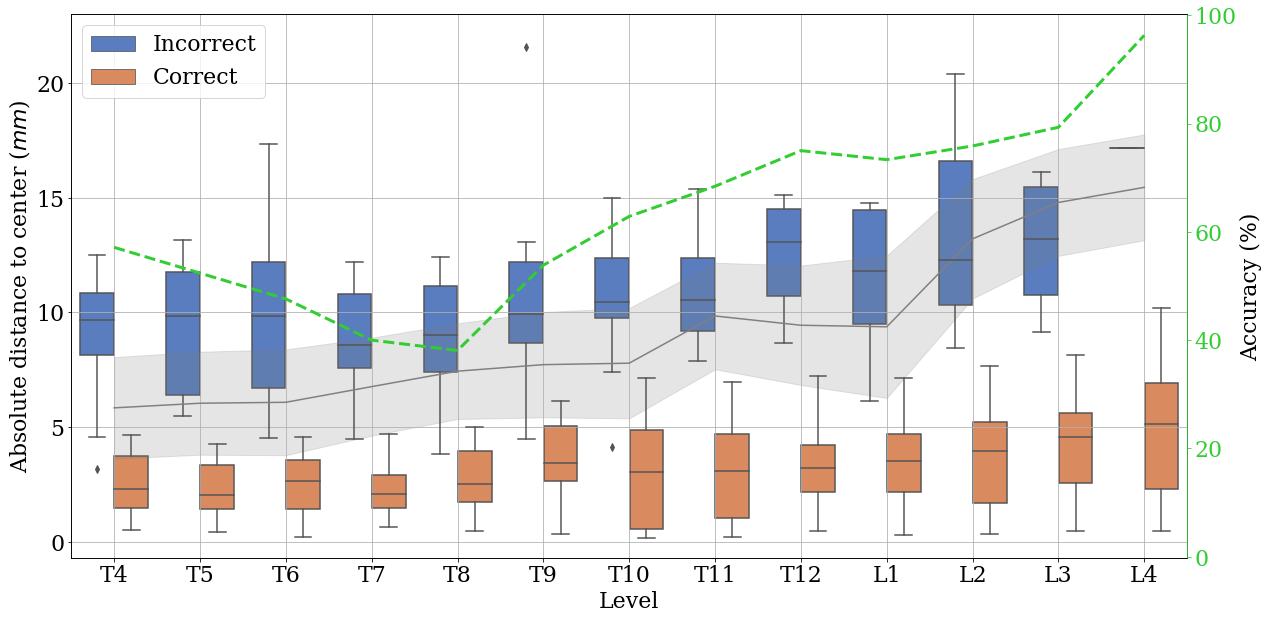

In [20]:
plt.style.use('seaborn-bright')
fig, ax = plt.subplots(1, 1,figsize=(20, 10))

sns.color_palette("hls", 2)
sns.boxplot(data=scores_df, x='Level', y='Distance', hue='Correct', linewidth=1.5,  order=ordered_verts, palette='muted', ax=ax)
g = sns.lineplot(data=scores_df, x= 'Level', y='Range', ci='sd', err_style="band", estimator='min', ax=ax, color='gray')
ax.set_ylabel('Absolute distance to center ($mm$)')
ax2 = ax.twinx()
ax2.set_ylabel('Accuracy (%)')
ax2.set_ylim([-0.2, 100.2])
sns.lineplot(data=accuracy, x=accuracy.index, y='Accuracy', ax=ax2, legend=False, ls='--', lw=3, color='limegreen' )
#sns.catplot(dara=scores_df, x='Level', y=, hue='Correct', kind='hist')
g.grid(True, which='both')
#g.axhline(y=0, color='k')
g.set_ylim([-0.7, 23])

# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = g.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = ax.legend(handles[0:2], labels[0:2], loc='upper left')

ax2.spines['right'].set_color('limegreen')
#ax2.yaxis.label.set_color('limegreen')
ax2.tick_params(axis='y', colors='limegreen')
l.get_texts()[0].set_text('Incorrect')
l.get_texts()[1].set_text('Correct')

## Update predictions

Apply post-processing to predictions.

In [21]:
from scipy.special import softmax

In [30]:
def linear_expectation(probs, values):
    # Assumes normalised probs + single channel
    expectation = []
    for i in range(len(values)):
        expectation.append(probs[i]*values[i])
    return np.sum(expectation)

In [54]:
def update_preds(name, num_iters=0):
    # k = number of iterations
    data = distribution_dict[name]
    x = np.arange(0, data.shape[-1])
    # Get predictions afs dict
    updated_pred = {}
    if num_iters==0:
        print('Not updating...')
        return pred_dict[name]
    else:
        # Normalise across channels & update
        for k in range(num_iters):
            channel_norm = data/data.sum(axis=0, keepdims=True)
            data = data*channel_norm
        for key in pred_dict[name].keys():
            norm_data = data[ordered_verts.index(key)]/np.sum(data[ordered_verts.index(key)])
            coords = linear_expectation(norm_data, x)
            #print(coords)
            updated_pred[key] = coords 
        return updated_pred

In [64]:
updated_preds = {}
for name in ids:
    updated_preds[name] = update_preds(name, num_iters=1)

In [65]:
levels = []
correct = []
distances = []
range_list = []
for name in ids:
    level, cor, dist, ranges = get_scores(name, updated_preds, plot=False)
    levels.extend(level)
    correct.extend(cor)
    distances.extend(dist)
    range_list.extend(ranges)

In [66]:
upd_scores = pd.DataFrame(columns=['Level', 'Correct', 'Distance', 'Range'])
upd_scores['Level'] = levels
upd_scores['Correct'] = correct
upd_scores['Distance'] = distances
upd_scores['Range'] = range_list
upd_scores.head()

,Level,Correct,Distance,Range
0,T10,False,8.408096,16.191523
1,T11,True,7.292567,17.017223
2,T12,True,4.698849,18.565876
3,L1,True,5.090501,20.152865
4,L2,True,3.790899,21.391757


In [67]:
upd_scores['Level'] = pd.Categorical(upd_scores['Level'],
                                   categories=ordered_verts,
                                   ordered=True)
table = pd.DataFrame(upd_scores.groupby('Level')['Correct'].value_counts(normalize=True)*100).transpose()
table.index = ['Accuracy']

upd_accuracy = {level: table[level, True] for level in ordered_verts}
upd_accuracy = pd.DataFrame(upd_accuracy).T

In [68]:
upd_accuracy


,Accuracy
T4,23.809524
T5,42.857143
T6,42.857143
T7,40.000000
T8,38.095238
T9,57.692308
T10,57.142857
T11,71.052632
T12,75.000000
L1,73.333333


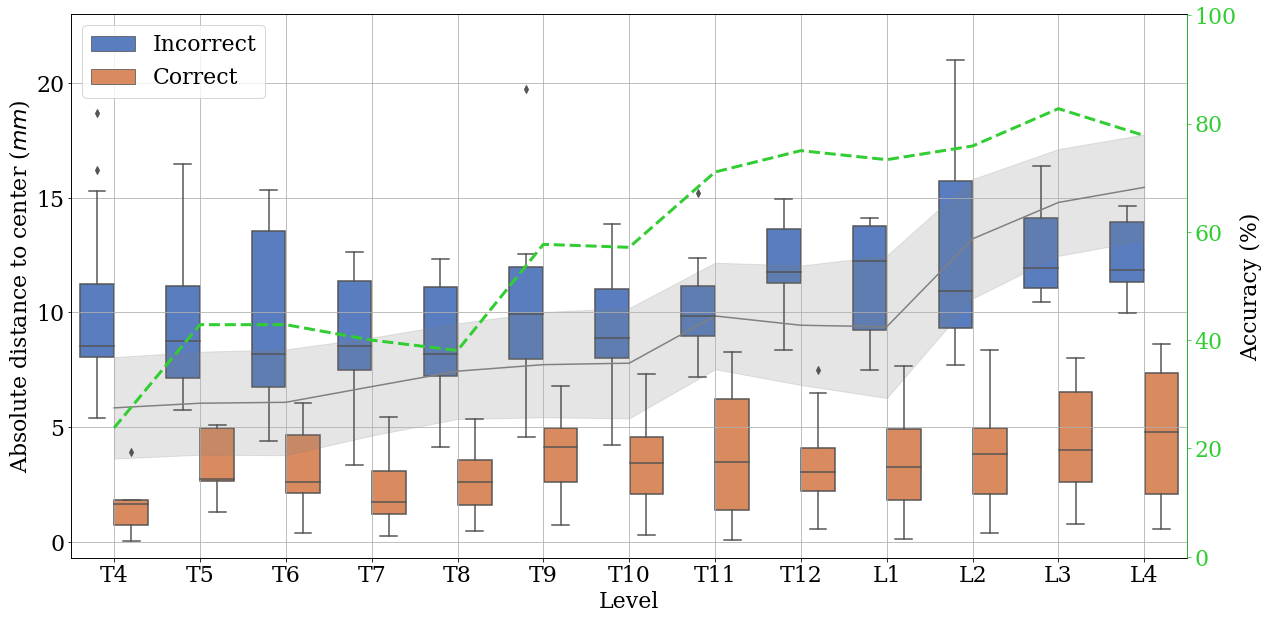

In [69]:
plt.style.use('seaborn-bright')
fig, ax = plt.subplots(1, 1,figsize=(20, 10))

sns.color_palette("hls", 2)
sns.boxplot(data=upd_scores, x='Level', y='Distance', hue='Correct', linewidth=1.5,  order=ordered_verts, palette='muted', ax=ax)
g = sns.lineplot(data=upd_scores, x= 'Level', y='Range', ci='sd', err_style="band", estimator='min', ax=ax, color='gray')
ax.set_ylabel('Absolute distance to center ($mm$)')
ax2 = ax.twinx()
ax2.set_ylabel('Accuracy (%)')
ax2.set_ylim([-0.2, 100.2])
sns.lineplot(data=upd_accuracy, x=upd_accuracy.index, y='Accuracy', ax=ax2, legend=False, ls='--', lw=3, color='limegreen' )
#sns.catplot(dara=scores_df, x='Level', y=, hue='Correct', kind='hist')
g.grid(True, which='both')
#g.axhline(y=0, color='k')
g.set_ylim([-0.7, 23])

# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = g.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = ax.legend(handles[0:2], labels[0:2], loc='upper left')

ax2.spines['right'].set_color('limegreen')
#ax2.yaxis.label.set_color('limegreen')
ax2.tick_params(axis='y', colors='limegreen')
l.get_texts()[0].set_text('Incorrect')
l.get_texts()[1].set_text('Correct')

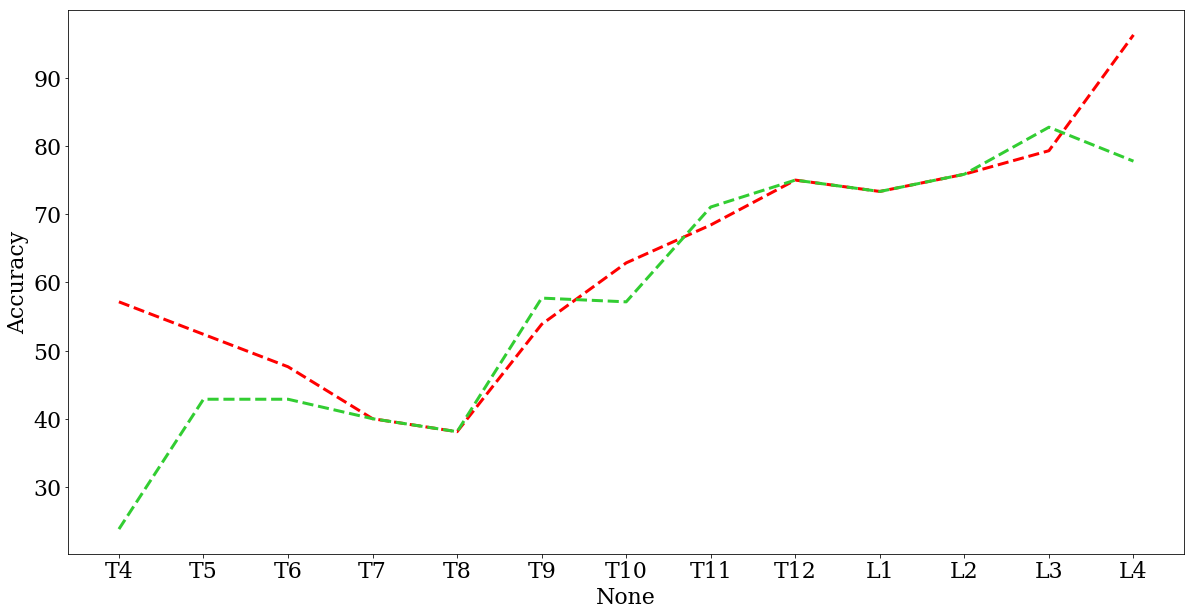

In [70]:
fig, ax = plt.subplots(1, 1,figsize=(20, 10))
sns.lineplot(data=accuracy, x=accuracy.index, y='Accuracy', ax=ax, legend=False, ls='--', lw=3, color='Red' )
sns.lineplot(data=upd_accuracy, x=upd_accuracy.index, y='Accuracy', ax=ax, legend=False, ls='--', lw=3, color='limegreen')

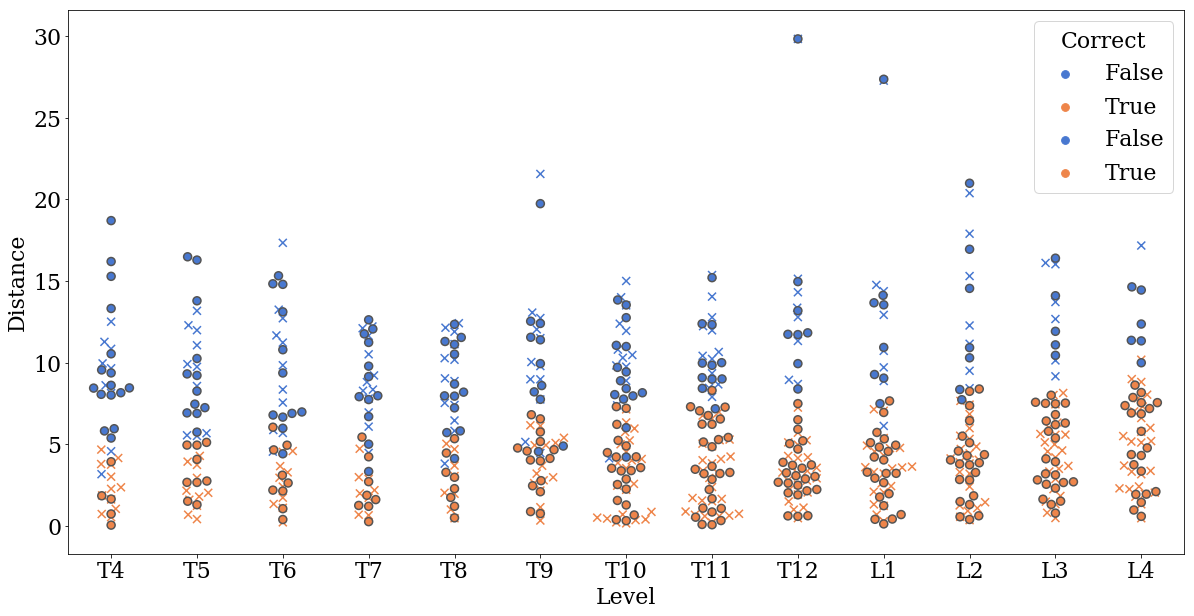

In [77]:
fig, ax = plt.subplots(1, 1,figsize=(20, 10))

sns.swarmplot(data=scores_df, x='Level', y='Distance', hue='Correct', linewidth=1.5, marker='x', order=ordered_verts, palette='muted', ax=ax, s=8)
sns.swarmplot(data=upd_scores, x='Level', y='Distance', hue='Correct', linewidth=1.5,order=ordered_verts, palette='muted', ax=ax, s=8)


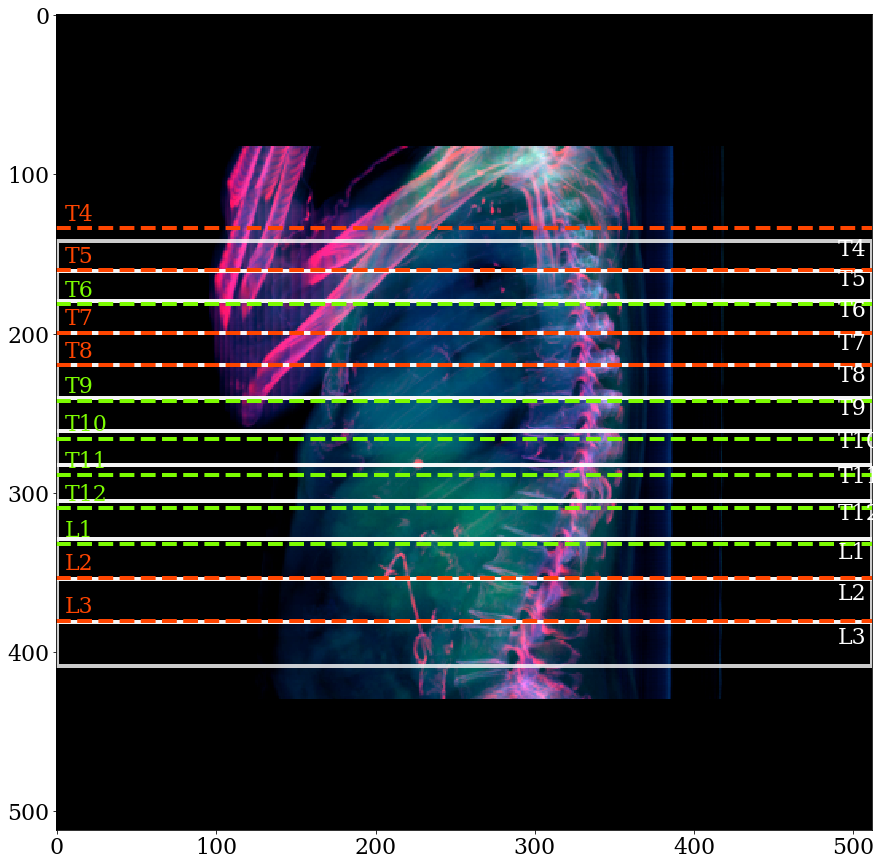

In [87]:
plot_preds('fr_552_TS_Sag', updated_preds)

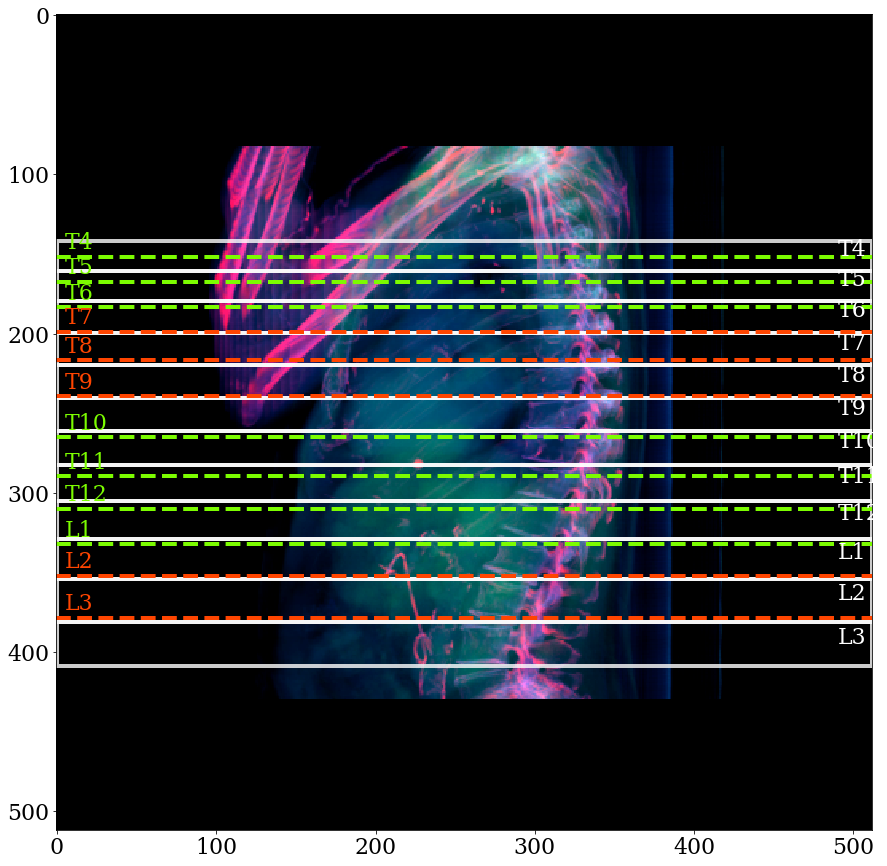

In [88]:
plot_preds('fr_552_TS_Sag', pred_dict)